In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import missingno as msno
from sklearn.base import TransformerMixin
from datetime import datetime
from scipy import stats
import math
## sklearn imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.feature_selection import RFE, RFECV
from sklearn.feature_selection import SelectKBest

from sklearn.metrics import classification_report, confusion_matrix, r2_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, \
    RandomForestClassifier, ExtraTreesClassifier

from xgboost import XGBClassifier
from sklearn.externals import joblib

In [2]:
pd.options.display.max_rows = 200
pd.options.display.max_columns = 100

# Functions

In [109]:
def run_regression_model(x_train, x_test, y_train, y_test, model):
    model.fit(x_train, y_train)
    print(model)
    print("Training set r score: ", model.score(x_train, y_train))
    print("Test set r score: ", model.score(x_test, y_test))
    predictions = model.predict(x_test)
    print("Mean Absolute Error on Test Set:", mean_absolute_error(y_test, predictions))
    print("Mean Squared Error on Test Set:", mean_squared_error(y_test, predictions))
    plt.scatter(y_test, predictions)
    plt.ylabel('Predicted Score')
    plt.xlabel('Actual Score')
    plt.plot([0, 5], [0, 5])
    plt.show()
    plt.clf()

In [80]:
def rating_classes(rating):
    if rating < 3.25:
        return 0
    elif rating >= 4.0:
        return 2
    else:
        return 1

def end_to_end(dataframe, class_model=None, low_model=None, mid_model=None, high_model=None, features=None, threshold=0.2):
    dataframe['rating_class'] = dataframe['rating'].apply(rating_classes)
    predictions = []
    print('Predicting row classes...')
    probabilities = class_model.predict_proba(dataframe[features].values) ## prediction inputs--> features as arguments???? 
    ### need values call???
#     print(probabilities)
#     print(len(probabilities))
    for probability in probabilities:    
        if probability[0] > threshold:
            predictions.append(0)
        elif probability[2] > threshold:
            predictions.append(2)
        else:
            predictions.append(1)
#     print(predictions)
#         #### maybe a confusion matrix here???
    print('Done classifying! Classification results: ')
    print("\nConfusion Matrix:\n", pd.DataFrame(confusion_matrix(dataframe['rating_class'], predictions), 
                                              columns=['predicted_0', 'predicted_1', 'predicted_2'],
                                                index=['is_0', 'is_1', 'is_2']))
    print("\nClassification Report:\n",classification_report(dataframe['rating_class'], predictions))
    dataframe['predicted_class'] = predictions
    print('Predicting low values...')
    lows = dataframe[dataframe['predicted_class'] == 0].copy()
    lows['predicted_rating'] = low_model.predict(lows[features].values)
    print('Predicting middle values...')
    mids = dataframe[dataframe['predicted_class'] == 1].copy()
    mids['predicted_rating'] = mid_model.predict(mids[features].values)
    print('Predicting high values...')
    highs = dataframe[dataframe['predicted_class'] == 2].copy()
    highs['predicted_rating'] = high_model.predict(highs[features].values)
    print('Done predicting!\nScoring predictions...')
    final_frame = pd.concat([lows, mids, highs])
    actuals = final_frame['rating']
    predictions = final_frame['predicted_rating']
    print("r^2 on Test Set:", r2_score(actuals, predictions))
    print("Mean Absolute Error on Test Set:", mean_absolute_error(actuals, predictions))
    print("Mean Squared Error on Test Set:", mean_squared_error(actuals, predictions))
    low_actual = final_frame[final_frame['rating_class'] == 0].copy()
    mid_actual = final_frame[final_frame['rating_class'] == 1].copy()
    high_actual = final_frame[final_frame['rating_class'] == 2].copy()
    plt.scatter(low_actual['rating'], low_actual['predicted_rating'], marker='x', s=1, color='black')
    plt.scatter(mid_actual['rating'], mid_actual['predicted_rating'], marker='x', s=1, color='#ffff00')
    plt.scatter(high_actual['rating'], high_actual['predicted_rating'], marker='x', s=1, color='r')
    plt.ylabel('Predicted Score')
    plt.xlabel('Actual Score')
    plt.axis([2, 5, 2, 5])
    plt.plot([0, 5], [0, 5])
    #### change size, resolution, and zoom of plot
    plt.show()
    plt.clf()
    final_frame['error'] = final_frame['predicted_rating'] - final_frame['rating']
    final_frame['abs_error'] = abs(final_frame['predicted_rating'] - final_frame['rating'])
    return final_frame

# Importing Data

In [20]:
data = pd.read_csv('data/database/master.csv', index_col=0)
data['date_added'] = data['date_added'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
data['date_brewery_added'] = data['date_brewery_added'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [130]:
_, df = train_test_split(data, train_size=0.8, random_state=5752)
print(_.shape, df.shape)
lil_df = df.copy()

(564999, 141) (141250, 141)


# Feature Selection

In [140]:
style_features = ['in_smokes', 'in_ryes', 'in_spiced', 'in_trad_german', 'in_trad_brit', 'in_thicks',
       'in_fall_winter', 'in_lager_lager', 'in_subpremiums', 'in_porters',
       'in_stouts', 'in_browns', 'in_yeasty_belgians', 'in_light_ales',
       'in_ambers', 'in_wheats', 'in_pilsners', 'in_sours', 'in_pale_ales',
       'in_ipas', 'in_ales', 'in_lagers', 'in_others', 'in_strongs']

brewery_types = ['Brew Pub', 'Cidery / Meadery', 'Collaboration Brewery', 'Home Brewery',
       'Macro Brewery', 'Micro Brewery', 'Nano Brewery']

random_bools = ['brewery_closed', 'is_subsidiary', 'official_account', 'oop', 
                'brewery_has_description', 'has_description']

numeric_features = ['raters', 'brewery_raters', 'brewery_num_beers',
                    'total_checkins', 'unique_checkins', 'monthly_checkins', 
                    'total_brewery_checkins', 'unique_brewery_checkins', 
                    'monthly_brewery_checkins', 'style_frequency']

date_features = ['date_added', 'date_brewery_added']

country_features = ['United States',
       'Norway', 'Brazil', 'England', 'Sweden', 'Netherlands', 'Canada',
       'Germany', 'Australia', 'France', 'Italy', 'Belgium', 'Russia',
       'Mexico', 'Spain', 'New Zealand', 'Denmark', 'Finland', 'Scotland',
       'Czech Republic']

state_features = ["AK","AL","AR","AZ","CA","CO","CT","DC",
                "DE","FL","GA","GU","HI","IA","ID", "IL",
                "IN","KS","KY","LA","MA","MD","ME","MH",
                "MI","MN","MO","MS","MT","NC","ND","NE","NH",
                "NJ","NM","NV","NY", "OH","OK","OR","PA","PR",
                "PW","RI","SC","SD","TN","TX","UT","VA","VI",
                "VT","WA","WI","WV","WY"]

aas_yet_unused = ['abv', 'ibu', 'description', 'beer_id', 'brewery_id', 'brewery_name',
                  'brewery_description', 'brewery_location', 'brewery_rating', 
                  'subsidiary_id', 'subsidiary_name',]
        


features = style_features + brewery_types + random_bools + numeric_features + state_features + country_features
print(len(features))
# features_to_remove = ['in_smokes', 'in_lager_lager', 'in_others', 'Brew Pub', 'brewery_raters', 'unique_checkins',
#                      'unique_brewery_checkins']

# for feature in features_to_remove:
#     features.remove(feature)

123


# Importing Model Objects

In [131]:
#### pipline objects ought to perform their own feature selection!!!!!

dataframe = lil_df
class_model = joblib.load('data/pickle_jar/classifier.pkl')
low_model = joblib.load('data/pickle_jar/low_model.pkl')
mid_model = joblib.load('data/pickle_jar/mid_model.pkl')
high_model = joblib.load('data/pickle_jar/high_model.pkl')
stratified_regressor = joblib.load('data/pickle_jar/stratified_regressor.pkl')
features = features

# Running Model 

Predicting row classes...
Done classifying! Classification results: 

Confusion Matrix:
       predicted_0  predicted_1  predicted_2
is_0         9417         7580          139
is_1         8559        92088         7164
is_2          147         8866         7290

Classification Report:
              precision    recall  f1-score   support

          0       0.52      0.55      0.53     17136
          1       0.85      0.85      0.85    107811
          2       0.50      0.45      0.47     16303

avg / total       0.77      0.77      0.77    141250

Predicting low values...
Predicting middle values...
Predicting high values...
Done predicting!
Scoring predictions...
r^2 on Test Set: 0.443811076822
Mean Absolute Error on Test Set: 0.188939152242
Mean Squared Error on Test Set: 0.0711364186735


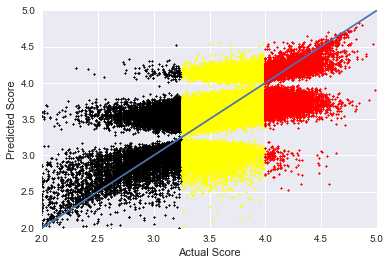

In [141]:
df_result = end_to_end(dataframe, class_model, low_model, mid_model, high_model, features, .6)

In [143]:
df_result['abs_error'].describe()

count    1.412500e+05
mean     1.889392e-01
std      1.882516e-01
min      8.773804e-07
25%      5.150072e-02
50%      1.335599e-01
75%      2.659294e-01
max      2.553508e+00
Name: abs_error, dtype: float64

In [134]:
df_result.groupby('rating_class')['abs_error'].describe()

rating_class       
0             count    1.713600e+04
              mean     3.002047e-01
              std      2.619020e-01
              min      3.397942e-05
              25%      7.862727e-02
              50%      2.599502e-01
              75%      4.443461e-01
              max      2.553508e+00
1             count    1.078110e+05
              mean     1.598474e-01
              std      1.563998e-01
              min      8.773804e-07
              25%      4.810606e-02
              50%      1.172092e-01
              75%      2.196622e-01
              max      1.681458e+00
2             count    1.630300e+04
              mean     2.643709e-01
              std      2.211186e-01
              min      8.316040e-06
              25%      6.791421e-02
              50%      2.435160e-01
              75%      4.002694e-01
              max      1.970440e+00
Name: abs_error, dtype: float64

In [153]:
df_result.sort_values(by='abs_error', ascending=False, inplace=True)
df_result.head(632)

,name,brewery,style,rating,raters,abv,ibu,total_checkins,unique_checkins,monthly_checkins,date_added,description,beer_id,brewery_id,oop,has_description,brewery_name,brewery_description,brewery_location,brewery_num_beers,brewery_raters,brewery_rating,date_brewery_added,monthly_brewery_checkins,subsidiary_id,subsidiary_name,total_brewery_checkins,unique_brewery_checkins,brewery_closed,is_subsidiary,official_account,Bar / Restaurant / Store,Brew Pub,Cidery / Meadery,Collaboration Brewery,Home Brewery,Macro Brewery,Micro Brewery,Nano Brewery,United States,Norway,Brazil,England,Sweden,Netherlands,Canada,Germany,Australia,France,Italy,...,OH,OK,OR,PA,PR,PW,RI,SC,SD,TN,TX,UT,VA,VI,VT,WA,WI,WV,WY,brewery_has_description,in_smokes,in_ryes,in_spiced,in_trad_german,in_trad_brit,in_thicks,in_fall_winter,in_lager_lager,in_subpremiums,in_porters,in_stouts,in_browns,in_yeasty_belgians,in_light_ales,in_ambers,in_wheats,in_pilsners,in_sours,in_pale_ales,in_ipas,in_ales,in_lagers,in_others,style_frequency,in_strongs,rating_class,predicted_class,predicted_rating,error,abs_error
440071,Boss Fruit Punch,Stout Brewing Co.,Malt Liquor,1.01,32.0,14.00,NaN,41.0,41.0,0.0,2015-08-28,NaN,1215269,148195,0,0,Stout Brewing Co.,Stout Brewing Company was founded in 2012 with...,"Kings Mountain, NC United States",18.0,1380.0,2.40,2014-08-04,39.0,NaN,NaN,1722.0,1350.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,963.0,0,0,1,3.563508,2.553508,2.553508
107091,Side Pocket High Gravity Malt Liquor,City Brewery,Malt Liquor,1.40,52.0,10.50,NaN,85.0,70.0,0.0,2012-10-14,NaN,246586,381,0,0,City Brewery,NaN,"La Crosse, WI United States",48.0,5041.0,2.42,2010-10-06,85.0,NaN,NaN,8356.0,4964.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,963.0,0,0,1,3.537804,2.137804,2.137804
404186,559 RHA (RWW Hef Ale),W Brewing,Hefeweizen,1.49,21.0,5.00,15.0,25.0,22.0,0.0,2015-06-06,German Hefeweizen Wheat Beer characterized by ...,1115444,38940,0,1,W Brewing,W BREWING utilizes a traditional German brewin...,"Clovis, CA United States",12.0,1181.0,2.47,2012-11-02,21.0,NaN,NaN,1381.0,810.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,12622.0,0,0,1,3.530457,2.040457,2.040457
484017,Sunnmørsjul (2015),Trollbryggeriet,Winter Warmer,1.65,20.0,6.00,NaN,20.0,20.0,0.0,2015-11-28,NaN,1332771,4062,1,0,Trollbryggeriet,NaN,"Liabygda, 6212 Norway",18.0,16946.0,3.10,2010-12-20,438.0,NaN,NaN,19529.0,9184.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2438.0,0,0,1,3.629306,1.979306,1.979306
138426,Quelque Chose (1997),Unibroue,Fruit Beer,4.57,19.0,8.00,21.0,21.0,20.0,0.0,2013-03-25,NaN,333736,1307,1,0,Unibroue,The first brewery of its kind in North America...,"Chambly, QC Canada",55.0,497220.0,3.82,2010-10-06,11644.0,4779,Sapporo Breweries,692341.0,254175.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,10841.0,0,2,0,2.599560,-1.970440,1.970440
152212,Tafel Stout,Brouwerij Martens,Stout - Other,1.67,181.0,1.35,30.0,212.0,196.0,2.0,2013-05-25,This beer is more sugar than beer honestly. Do...,372326,26017,0,1,Brouwerij Martens,Brouwerij Martens is een bierbrouwerij in Boch...,"Bocholt, Limburg Belgium",167.0,64311.0,2.83,2011-01-16,3503.0,NaN,NaN,86823.0,46994

Test set r score:  0.385601423656
Mean Absolute Error on Test Set: 0.211053890973
Mean Squared Error on Test Set: 0.0785814181799


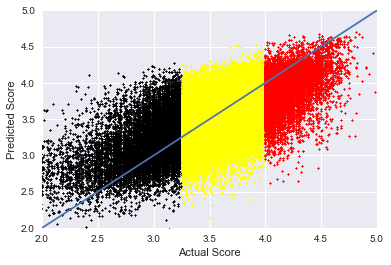

In [136]:
x = dataframe[features].values
dataframe['rating_class'] = dataframe['rating'].apply(rating_classes)
y = dataframe['rating'].values
print("Test set r score: ", stratified_regressor.score(x, y))
dataframe['predicted_rating'] = stratified_regressor.predict(x)
predictions = dataframe['predicted_rating']
print("Mean Absolute Error on Test Set:", mean_absolute_error(y, predictions))
print("Mean Squared Error on Test Set:", mean_squared_error(y, predictions))
low_actual = dataframe[dataframe['rating_class'] == 0].copy()
mid_actual = dataframe[dataframe['rating_class'] == 1].copy()
high_actual = dataframe[dataframe['rating_class'] == 2].copy()
plt.scatter(low_actual['rating'], low_actual['predicted_rating'], marker='x', s=1, color='black')
plt.scatter(mid_actual['rating'], mid_actual['predicted_rating'], marker='x', s=1, color='#ffff00')
plt.scatter(high_actual['rating'], high_actual['predicted_rating'], marker='x', s=1, color='r')
plt.ylabel('Predicted Score')
plt.xlabel('Actual Score')
plt.axis([2, 5, 2, 5])
plt.plot([0, 5], [0, 5])
#### change size, resolution, and zoom of plot
plt.show()
plt.clf()
dataframe['error'] = dataframe['predicted_rating'] - dataframe['rating']
dataframe['abs_error'] = abs(dataframe['predicted_rating'] - dataframe['rating'])

In [137]:
dataframe['abs_error'].describe()

count    141250.000000
mean          0.211054
std           0.184494
min           0.000000
25%           0.074900
50%           0.164100
75%           0.296100
max           2.271600
Name: abs_error, dtype: float64